<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/centernet_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Hughes Perreault <br>
Inspired and partly copied from: https://github.com/tugstugi/dl-colab-notebooks <br>
Original GitHub: https://github.com/xingyizhou/CenterNet

Import libraries

In [2]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import numpy as np
import urllib.request
from skimage import io

plt.rcParams["axes.grid"] = False

Clone repo and install requirements, including the DCNv2 network. This might take some time.

In [ ]:
!pip install -U torch==1.4 torchvision==0.5 -f https://download.pytorch.org/whl/cu101/torch_stable.html

git_repo_url = 'https://github.com/xingyizhou/CenterNet.git'
project_name = os.path.splitext(os.path.basename(git_repo_url))[0]
if not os.path.exists(project_name):
  # clone
  !git clone -q --depth 1 $git_repo_url
  # fix DCNv2
  !cd {project_name}/src/lib/models/networks && rm -rf DCNv2 && git clone https://github.com/CharlesShang/DCNv2.git && cd DCNv2 && ./make.sh
  # dependencies
  !cd $project_name && pip install -q -r requirements.txt

sys.path.insert(0, os.path.join(project_name, 'src/lib'))
sys.path.append(os.path.join(project_name, 'src'))
# following 2 lines needed to avoid later import error
sys.path.append(os.path.join(project_name, 'src/lib/models/networks/DCNv2'))
from dcn_v2 import DCN

Download pre-trained weights on COCO.<br>
Initialize detector with arguments.

In [4]:
model_name = 'ctdet_coco_dla_2x.pth'
if not os.path.exists(model_name):
  !pip install -q gdown
  !gdown 'https://drive.google.com/uc?id=1pl_-ael8wERdUREEnaIfqOV_VF2bEVRT' # 37.4mAP

from opts import opts
from detectors.detector_factory import detector_factory

# CenterNet opts want argv, so overwrite it
import sys
sys.argv = ['centernet', 'ctdet']
opt = opts().init()
opt.load_model = model_name
# uncomment below for automatic vizualisation
# opt.debug = 1

Detector = detector_factory[opt.task]
detector = Detector(opt)

Downloading...
From: https://drive.google.com/uc?id=1pl_-ael8wERdUREEnaIfqOV_VF2bEVRT
To: /content/ctdet_coco_dla_2x.pth
80.9MB [00:01, 66.0MB/s]
NMS not imported! If you need it, do 
 cd $CenterNet_ROOT/src/lib/external 
 make
NMS not imported! If you need it, do 
 cd $CenterNet_ROOT/src/lib/external 
 make
Fix size testing.
training chunk_sizes: [32]
The output will be saved to  CenterNet/src/lib/../../exp/ctdet/default
heads {'hm': 80, 'wh': 2, 'reg': 2}
Creating model...


Downloading: "http://dl.yf.io/dla/models/imagenet/dla34-ba72cf86.pth" to /root/.cache/torch/checkpoints/dla34-ba72cf86.pth



loaded ctdet_coco_dla_2x.pth, epoch 230


Define some constants


In [5]:
IMG_BASE_DIR = 'https://raw.githubusercontent.com/gabilodeau/INF6804/master/images'
IMG_NAMES = ['coffee0.jpg', 'coffee1.jpg', 'coffee2.jpg']
THRESHOLD = 0.5  # The confidence score threshold to display a detection box

Get a list of text labels for each integer class id

In [6]:
COCO_NAMES = ['background']
label_names = urllib.request.urlopen('https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names')
for label_name in label_names.readlines():
  COCO_NAMES.append(label_name.strip().decode('UTF-8'))

Get a list of different colors for each label to display the bounding boxes

In [7]:
COLORS = list(mcolors.CSS4_COLORS.values())

For each image in the list, get a list of detection boxes, then display thoses boxes on the image.

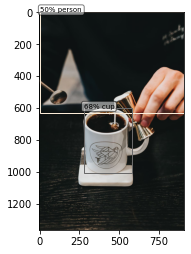

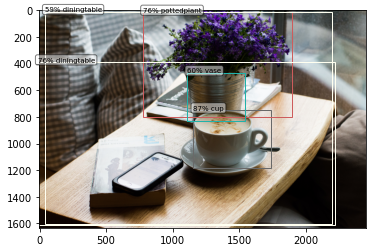

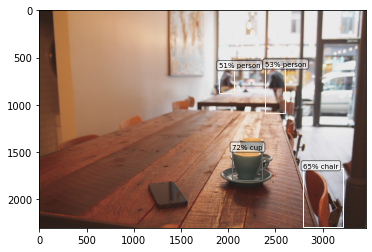

In [8]:
predictions = []
#
for img_name in IMG_NAMES:
  img = io.imread(os.path.join(IMG_BASE_DIR, img_name))
  ret = detector.run(img)
  predictions.append(ret['results'])

# For each image, display their predictions
for i, prediction in enumerate(predictions):
  boxes = []
  for j, label in enumerate(COCO_NAMES):
    if j in prediction:
      j_boxes = prediction[j]
      for box in j_boxes:
        score = box[4]
        if score >= THRESHOLD:
          boxes.append([box[0]] + [box[1]] + [box[2]] + [box[3]] + [j] + [box[4]])
  img = np.array(io.imread(os.path.join(IMG_BASE_DIR, IMG_NAMES[i])), dtype=np.uint8)
  fig, ax = plt.subplots(1)
  ax.imshow(img)


  for box in boxes:
    x0, y0, x1, y1, label, score = box
    rect = patches.Rectangle((x0, y0), (x1-x0), (y1-y0), linewidth=1, edgecolor=COLORS[label], facecolor='none')
    plt.text(x0, y0, str(int(score*100)) + '% ' + COCO_NAMES[label], color='k', fontsize=7,
              bbox=dict(facecolor='white', alpha=0.5, boxstyle='round'))
    ax.add_patch(rect)

  plt.show()
